### Importing Libraries

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import datetime

from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score , classification_report
from scipy.sparse import csr_matrix, hstack
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer,TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from gensim.models import Word2Vec


import scikitplot as skplt

import warnings
warnings.filterwarnings('ignore')


global_start = datetime.datetime.now()

### Loading Data

In [3]:
with open('finaldata.pkl', 'rb') as f: 
    final = pickle.load(f)

final = final.drop(columns=['index'])


In [4]:
print(final.shape)
final.head()

(364171, 11)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...
1,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,1,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",grew read sendak book watch realli rosi movi i...
2,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,1,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,fun way children learn month year learn poem t...
3,150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,1,1076025600,a good swingy rhythm for reading aloud,This is a great little book to read aloud- it ...,great littl book read nice rhythm well good re...
4,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,1,1018396800,A great way to learn the months,This is a book of poetry about the months of t...,book poetri month year goe month cute littl po...


### Random Sapmpling the Data (150,000 rows)

In [5]:
fsubset= final.sample(n = 150000,random_state=42).reset_index(drop = True)
print("Distribution of classes \n{}".format(fsubset['Score'].value_counts()))
print(fsubset.shape)


Distribution of classes 
1    126500
0     23500
Name: Score, dtype: int64
(150000, 11)


In [6]:
# Deleting from RAM
del final 

In [7]:
#Sorting by time
fsubset = fsubset.sort_values(by = ['Time'])

In [8]:
X = np.array(fsubset['CleanedText'])
print(X.shape)
y = np.array(fsubset['Score'])
print(y.shape)


(150000,)
(150000,)


In [9]:
fsubset['Text_Length'] = fsubset['Text'].apply(lambda x: len(x.split()))
print(fsubset.shape)
fsubset.head()

(150000, 12)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText,Text_Length
78027,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...,74
17281,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,1,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,rememb see show air televis year ago child sis...,78
145633,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,1,946857600,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,beetlejuic excel funni movi keaton hilari wack...,43
68981,374343,B00004CI84,A1B2IZU1JLZA6,Wes,19,23,0,948240000,WARNING: CLAMSHELL EDITION IS EDITED TV VERSION,"I, myself always enjoyed this movie, it's very...",alway enjoy movi funni entertain didnt hesit p...,68
19899,374450,B00004CI84,ACJR7EQF9S6FP,Jeremy Robertson,2,3,1,951523200,Bettlejuice...Bettlejuice...BETTLEJUICE!,What happens when you say his name three times...,happen say name three time michael keaten star...,223


### Train-Test Data splitting

In [10]:
X_train_train, X_test_train, y_train, y_test =train_test_split(X, y,test_size = 0.3,random_state = 42, shuffle = False)


In [11]:
print(X_train_train.shape)
print(X_test_train.shape)
print(y_train.shape)
print(y_test.shape)


(105000,)
(45000,)
(105000,)
(45000,)


### Cross Validation using Grid Search

In [26]:
# The following function performs hyperparameter tuning using cross-validation.
# We will find the optimum value of alpha by finding the hight weighted f-1 score
def gscv(regularisation):
    
    start = datetime.datetime.now()
    
    # values of C to iterate over.
    param_dict={}
    param_dict['C'] = [0.001, 0.01, 0.1, 0.5, 1, 10, 100]
    
    #Algorithm object
    clf = LogisticRegression(class_weight='balanced' , penalty = regularisation,n_jobs=4)
    
    # perform Grid Search cross validation
    model = GridSearchCV(estimator=clf , param_grid=param_dict, scoring='roc_auc' ,cv=2, refit=True)
    
    model.fit(X_train,y_train)
    
    param = param_dict['C']
    test_scores = model.cv_results_['mean_test_score']
    train_scores = model.cv_results_['mean_train_score']
    

    # Plot c v/s AUC-ROC
    plt.figure(figsize=(15,10))
    plt.plot(param, test_scores,'-o',label='Model Test Scores')
    plt.plot(param,train_scores,'-o',label ='Model Train Scores')
    plt.xlabel('AUC-ROC')
    plt.ylabel('Hyperparameter C')
    plt.title('Hyperparameter vs AUC Score')
    plt.legend()
    plt.show()

    print('Best model with the highest AUC score  : {}'.format(model.best_estimator_))
    print('AUC score of the best model : {}'.format(model.best_score_))
    print('Time taken to process the whole Cross validation is : {}'.format(datetime.datetime.now() - start))
    return model.best_estimator_
    
    

In [18]:
def top_words(model,featuriser):
    classfeature = model.fit(X_train,y_train).coef_[0]
    positivewords = classfeature.argsort()[::-1]
    negativewords = classfeature.argsort()
    print("Positve words are :{}".format(np.take(featuriser.get_feature_names(),positivewords[:10])))
    print("Negative words are :{}".format(np.take(featuriser.get_feature_names(),negativewords[:10])))

### Prediction report using various hyperparameters

In [14]:
# The following fucntion generates classification reports based on Test data predictions
def evaluate_test_predictions(clf):
    y_pred = clf.fit(X_train, y_train).predict(X_test)
    y_prob = clf.predict_proba(X_test)
    print('\n########## CLASSIFICATION REPORTS ON TEST DATA##########')
    print('accuracy on test data : {}'.format(accuracy_score(y_test, y_pred)))
    print(classification_report(y_test, y_pred))
    skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize=True)
    skplt.metrics.plot_roc(y_test, y_prob)
    skplt.metrics.plot_precision_recall_curve(y_test,y_prob)

    

### Binary Bag of Words 

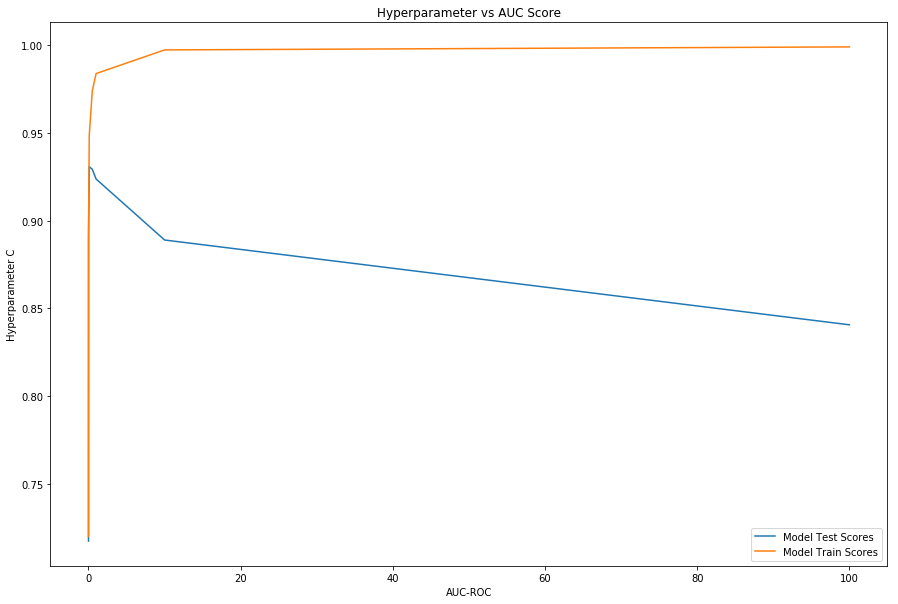

Best model with the highest AUC score  : LogisticRegression(C=0.1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=4, penalty='l1', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)
AUC score of the best model : 0.9306995655410897
Time taken to process the whole Cross validation is : 0:00:35.723840
[0. 0. 0. ... 0. 0. 0.]
Positve words are :['hook' 'delici' 'perfect' 'best' 'amaz' 'addict' 'uniqu' 'excel' 'great'
 'yum']
Negative words are :['worst' 'ugh' 'mediocr' 'aw' 'terribl' 'disappoint' 'yuck' 'bland'
 'refund' 'tasteless']

########## CLASSIFICATION REPORTS ON TEST DATA##########
accuracy on test data : 0.8718222222222223
              precision    recall  f1-score   support

           0       0.59      0.87      0.70      7872
           1       0.97      0.87      0.92     37128

   micro avg       0.87      0.87      0.87     45000
   macro avg       

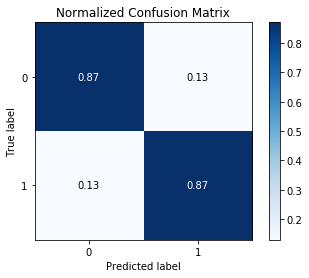

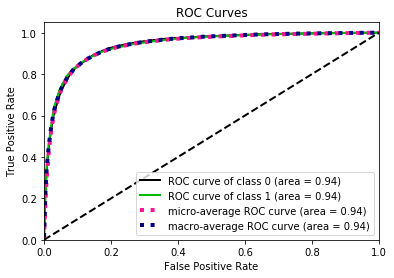

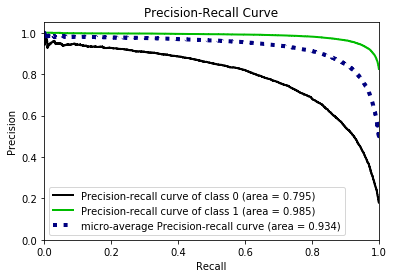

In [19]:
# ************** Creating Bag Of Words ***************************
count_vec = CountVectorizer(binary=True)
X_train = count_vec.fit_transform(X_train_train)
X_test = count_vec.transform(X_test_train)

# cross validation

model=gscv(regularisation ='l1')
top_words(model,count_vec)
evaluate_test_predictions(model)

### Count Binary Bag of words

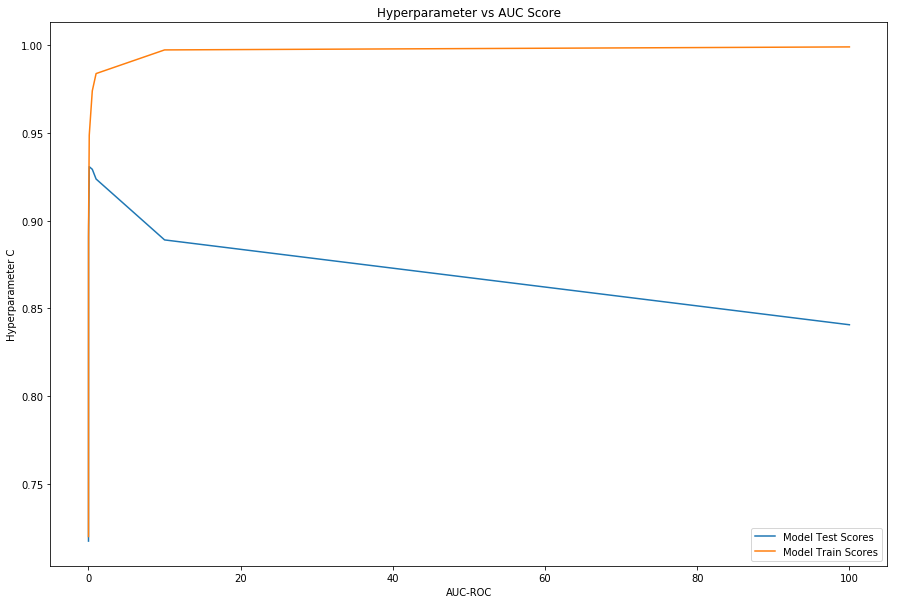

Best model with the highest AUC score  : LogisticRegression(C=0.1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=4, penalty='l1', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)
AUC score of the best model : 0.9306995225828605
Time taken to process the whole Cross validation is : 0:00:35.388272
Positve words are :[['worst' 'ugh' 'mediocr' ... 'perfect' 'delici' 'hook']]
Negative words are :[['worst' 'ugh' 'mediocr' ... 'perfect' 'delici' 'hook']]

########## CLASSIFICATION REPORTS ON TEST DATA##########
accuracy on test data : 0.8718222222222223
              precision    recall  f1-score   support

           0       0.59      0.87      0.70      7872
           1       0.97      0.87      0.92     37128

   micro avg       0.87      0.87      0.87     45000
   macro avg       0.78      0.87      0.81     45000
weighted avg       0.90      0.87      0.88   

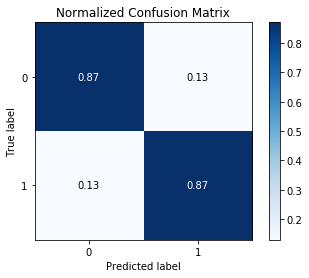

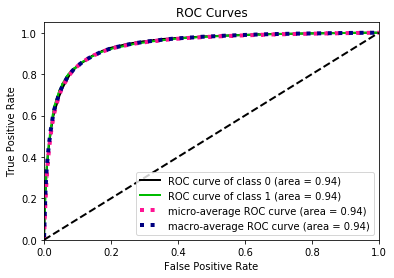

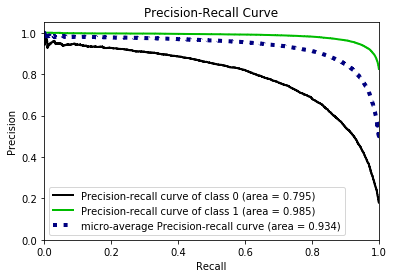

In [29]:
# ************** Creating Bag Of Words ***************************
count_vec = CountVectorizer(binary=True)
X_train = count_vec.fit_transform(X_train_train)
X_test = count_vec.transform(X_test_train)

# cross validation

model=gscv(regularisation ='l1')
top_words(model,count_vec)
evaluate_test_predictions(model)

### Tf-idf with l1 regularisation

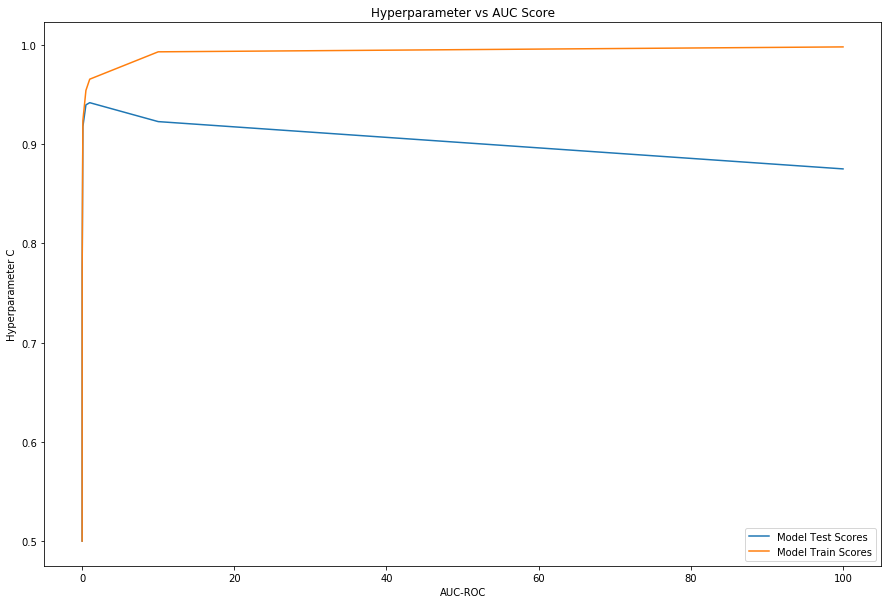

Best model with the highest AUC score  : LogisticRegression(C=1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=4, penalty='l1', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)
AUC score of the best model : 0.9417044600757157
Time taken to process the whole Cross validation is : 0:00:34.078442
[0. 0. 0. ... 0. 0. 0.]
Positve words are :['great' 'delici' 'perfect' 'best' 'love' 'hook' 'addict' 'amaz' 'excel'
 'skeptic']
Negative words are :['worst' 'disappoint' 'aw' 'terribl' 'unimpress' 'ugh' 'mediocr' 'horribl'
 'ined' 'bland']

########## CLASSIFICATION REPORTS ON TEST DATA##########
accuracy on test data : 0.8784888888888889
              precision    recall  f1-score   support

           0       0.61      0.88      0.72      7872
           1       0.97      0.88      0.92     37128

   micro avg       0.88      0.88      0.88     45000
   macro avg     

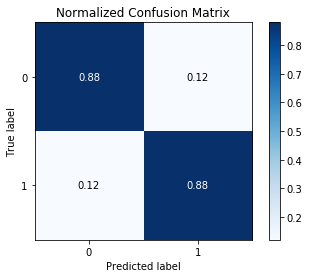

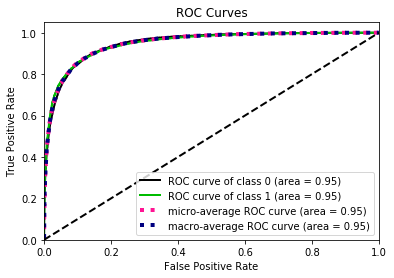

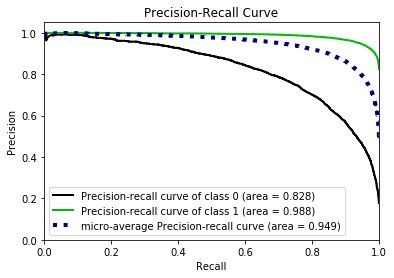

In [20]:
tf_idf_vect = TfidfVectorizer()
X_train = tf_idf_vect.fit_transform(X_train_train)
X_test = tf_idf_vect.transform(X_test_train)

# cross validation
# cross validation

model=gscv(regularisation ='l1')
top_words(model,tf_idf_vect)
evaluate_test_predictions(model)

###  Tf-idf with l2 regularisation

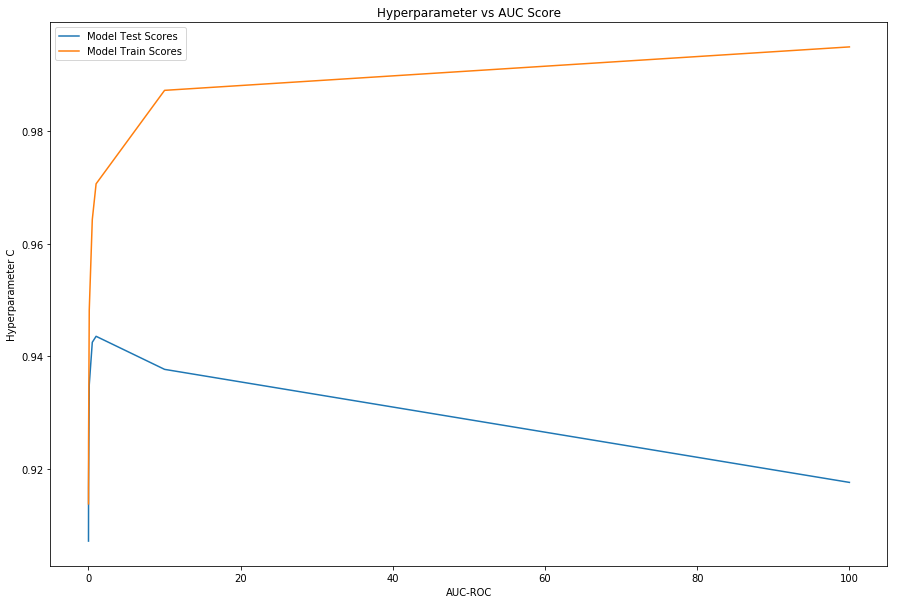

Best model with the highest AUC score  : LogisticRegression(C=1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=4, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)
AUC score of the best model : 0.9435791013530228
Time taken to process the whole Cross validation is : 0:00:25.570035
[ 0.10753562  0.44026659  0.003361   ...  0.01028042 -0.16907108
  0.03047008]
Positve words are :['great' 'best' 'delici' 'perfect' 'love' 'excel' 'nice' 'favorit' 'amaz'
 'good']
Negative words are :['worst' 'disappoint' 'aw' 'terribl' 'bland' 'horribl' 'unfortun' 'return'
 'weak' 'stale']

########## CLASSIFICATION REPORTS ON TEST DATA##########
accuracy on test data : 0.8800888888888889
              precision    recall  f1-score   support

           0       0.61      0.88      0.72      7872
           1       0.97      0.88      0.92     37128

   micro avg      

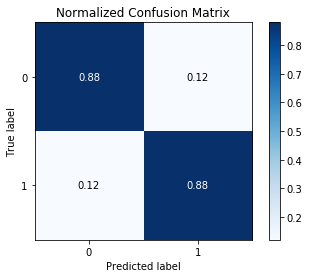

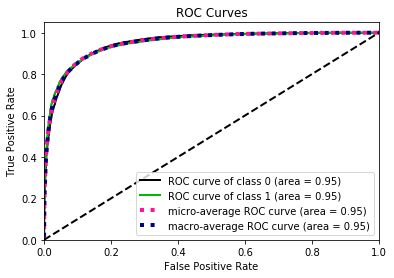

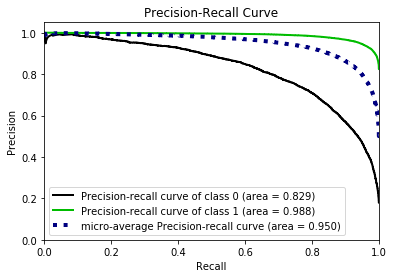

In [22]:
tf_idf_vect = TfidfVectorizer()
X_train = tf_idf_vect.fit_transform(X_train_train)
X_test = tf_idf_vect.transform(X_test_train)

# cross validation
# cross validation

model=gscv(regularisation ='l2')
top_words(model,tf_idf_vect)
evaluate_test_predictions(model)

### W2vec with l2 regularisation

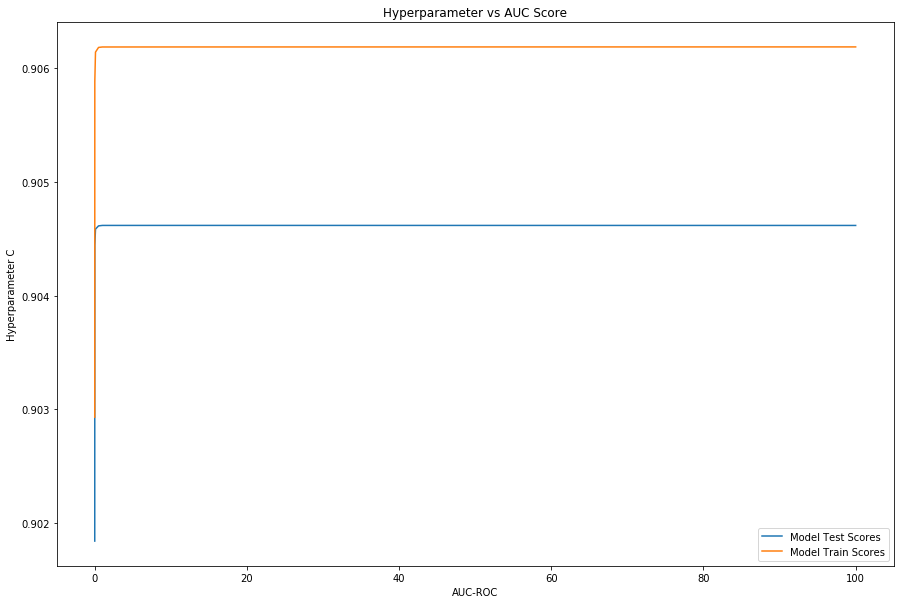

Best model with the highest AUC score  : LogisticRegression(C=10, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=4, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)
AUC score of the best model : 0.9046178504089298
Time taken to process the whole Cross validation is : 0:00:19.799507

########## CLASSIFICATION REPORTS ON TEST DATA##########
accuracy on test data : 0.8103777777777778
              precision    recall  f1-score   support

           0       0.48      0.85      0.61      7872
           1       0.96      0.80      0.87     37128

   micro avg       0.81      0.81      0.81     45000
   macro avg       0.72      0.83      0.74     45000
weighted avg       0.88      0.81      0.83     45000



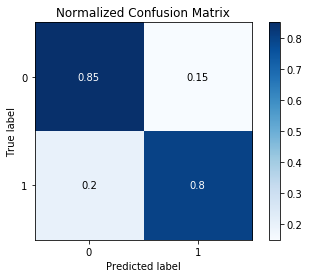

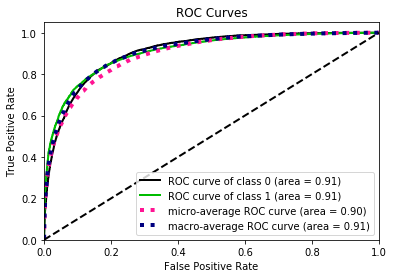

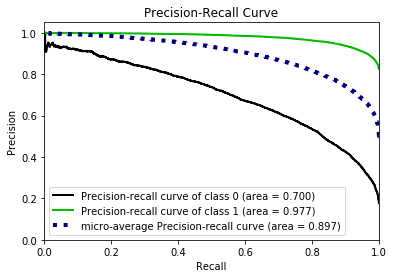

In [25]:
  # ******************* Tokenize training reviews ********************
review_list = []
for review in X_train_train:
    review_list.append(review.split())
    
# ****************** Word2Vec **********************
# min_count = 5 considers only words that occured atleast 5 times
w2v_model=Word2Vec(review_list,min_count=5,size=50, workers=4)
w2v_words = list(w2v_model.wv.vocab)

# *************** Converting training reviews to vectors ********************
X_train = []; # the avg-w2v for each sentence/review is stored in this list
for review in review_list: # for each review/sentence
    review_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words = 0; # num of words with a valid vector in the sentence/review
    for word in review: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            review_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        review_vec /= cnt_words
    X_train.append(review_vec)
X_train = np.array(X_train)

# ********** Tokenize test reviews *****************
review_list = []
for review in X_test_train:
    review_list.append(review.split())
    
# **************** Converting test reviews to vectors ****************
X_test = []; # the avg-w2v for each sentence/review is stored in this list
for review in review_list: # for each review/sentence
    review_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words = 0; # num of words with a valid vector in the sentence/review
    for word in review: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            review_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        review_vec /= cnt_words
    X_test.append(review_vec)
X_test = np.array(X_test)


model=gscv(regularisation ='l2')
evaluate_test_predictions(model)
    

In [28]:
# ******************* Tokenize training reviews ********************
review_list = []
for review in X_train_train:
    review_list.append(review.split())
    
# ********************** Word2Vec**************************
# min_count = 5 considers only words that occured atleast 5 times
w2v_model=Word2Vec(review_list,min_count=5,size=50, workers=4)
w2v_words = list(w2v_model.wv.vocab)    

# *********************** TF-IDF **************************
tfidf_vec = TfidfVectorizer()
tfidf_vec.fit(X_train_train)
idf_dict = dict(zip(tfidf_vec.get_feature_names(), tfidf_vec.idf_))

# ***************** Converting Training Reviews to vectors *************
X_train = []; # the avg-w2v for each sentence/review is stored in this list
for review in review_list: # for each review/sentence
    review_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum = 0; # num of words with a valid vector in the sentence/review
    for word in review: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            tf_idf = idf_dict[word]*(review.count(word)/len(review))
            review_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        review_vec /= weight_sum
    X_train.append(review_vec)
X_train = np.array(X_train)

# ********** Tokenize test reviews *****************
review_list = []
for review in X_test_train:
    review_list.append(review.split())
   
# ***************** Converting Test reviews to vectors *************
X_test = []; # the avg-w2v for each sentence/review is stored in this list
for review in review_list: # for each review/sentence
    review_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum = 0; # num of words with a valid vector in the sentence/review
    for word in review: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            tf_idf = idf_dict[word]*(review.count(word)/len(review))
            review_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        review_vec /= weight_sum
    X_test.append(review_vec)
X_test = np.array(X_test)

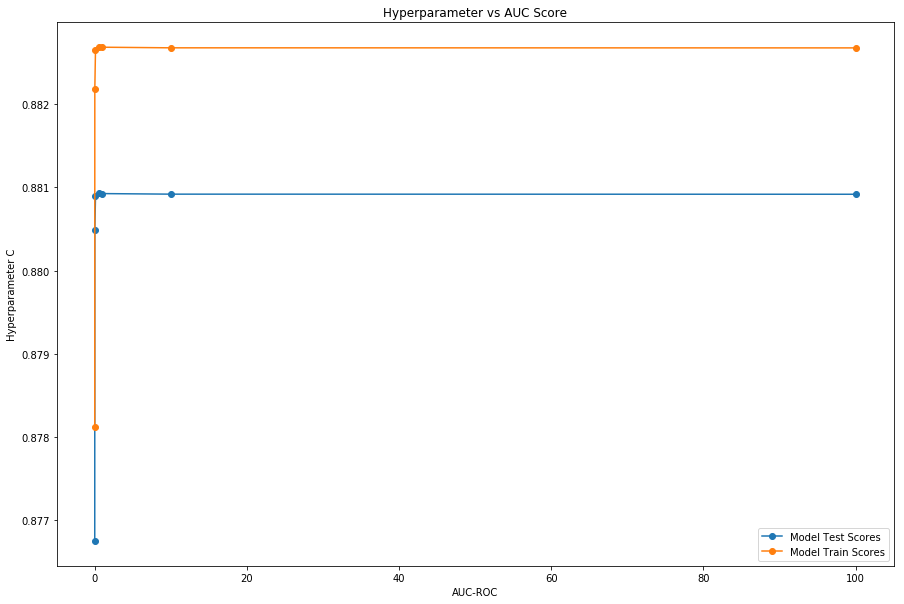

Best model with the highest AUC score  : LogisticRegression(C=0.5, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=4, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)
AUC score of the best model : 0.8809287554264404
Time taken to process the whole Cross validation is : 0:00:25.246713

########## CLASSIFICATION REPORTS ON TEST DATA##########
accuracy on test data : 0.7880222222222222
              precision    recall  f1-score   support

           0       0.44      0.82      0.57      7872
           1       0.95      0.78      0.86     37128

   micro avg       0.79      0.79      0.79     45000
   macro avg       0.70      0.80      0.72     45000
weighted avg       0.86      0.79      0.81     45000



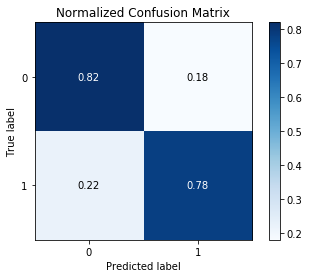

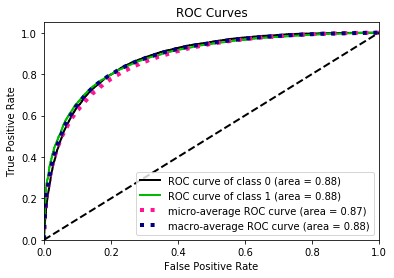

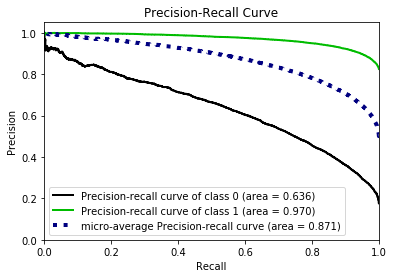

In [29]:
model=gscv(regularisation ='l2')
evaluate_test_predictions(model)